In [1]:
!kaggle competitions download -c spaceship-titanic

100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.31MB/s]
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 1.30MB/s]


# Prepping the Data

In [8]:
from zipfile import ZipFile
from pathlib import Path
import os

# Setup the title and create the data directory
title = 'spaceship-titanic'
DATA_PATH = Path(os.path.join("..", "data", title))
DATA_PATH.mkdir(parents=True, exist_ok=True)

# Open the zip file and extract to the datapath
with ZipFile('spaceship-titanic.zip', 'r') as zipObj:
   zipObj.extractall(DATA_PATH)

# Remove the zip file once complete
os.remove(title + '.zip')

# Introduction

Per Kaggle Data:

`train.csv` - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

`test.csv` - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

**Your task is to predict the value of Transported for the passengers in this set.** 

`sample_submission.csv` - A submission file in the correct format.
- `PassengerId` - Id for each passenger in the test set.
- `Transported` - The target. For each passenger, predict either True or False.

# EDA

In [10]:
# Base Imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style('whitegrid')

/Users/eliastavarez/opt/anaconda3/envs/jupyter39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
# Read in and check the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [12]:
# Review column data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [13]:
# Both Cryosleep and VIP are both objects but should be changed to bools
train[['CryoSleep', 'VIP']] = train[['CryoSleep', 'VIP']].astype(bool)

In [14]:
# Review the planets
for planet in train['Destination'].value_counts().index:
    print(planet)

TRAPPIST-1e
55 Cancri e
PSO J318.5-22


Let's begin to take a look at the data available to us, beginning with the homeplanets and destinations:

HomePlanet
Earth : 42.39
Europa : 65.88
Mars : 52.3


Destination
TRAPPIST-1e : 47.12
55 Cancri e : 61.0
PSO J318.5-22 : 50.38




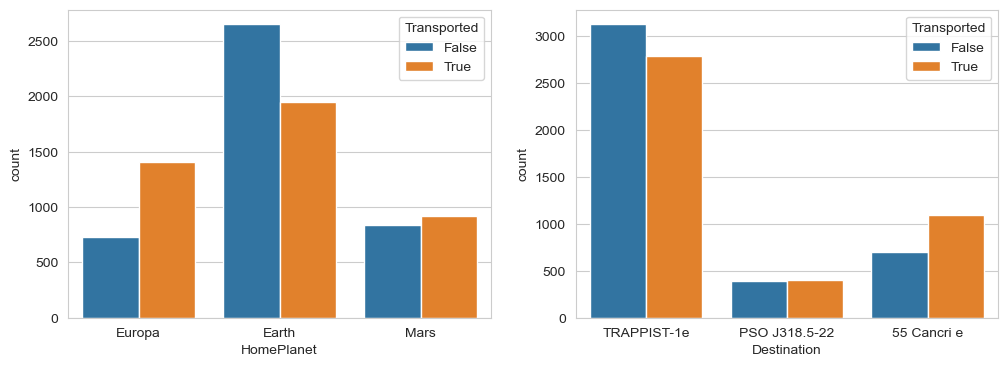

In [15]:
# Seeing that we only have three planets, let's look at the counts of survival here:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(x='HomePlanet', hue='Transported', data=train, ax=ax[0])
sns.countplot(x='Destination', hue='Transported', data=train, ax=ax[1])

# What's the percentage of those transported for each planet?
for col in ['HomePlanet', 'Destination']:
    print(col)
    for planet in train[col].value_counts().index:
        df_temp = train[train[col] == planet]
        transported = len(df_temp[df_temp['Transported'] == 1])
        print(planet, ':', round(transported/len(df_temp) * 100, 2))
    print('\n')

Most notably, Europa had the highest percentage of those transported while Earth has more passengers than both Europa and Mars combined.

When considering the desitnations, Trappist was the most popular destination by a LONG shot. However, the destination with the highest transported rate was 55 Cancri.

<AxesSubplot: xlabel='Transported', ylabel='TotalSpend'>

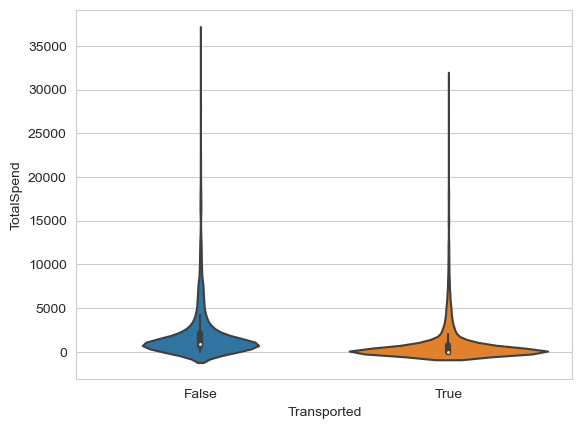

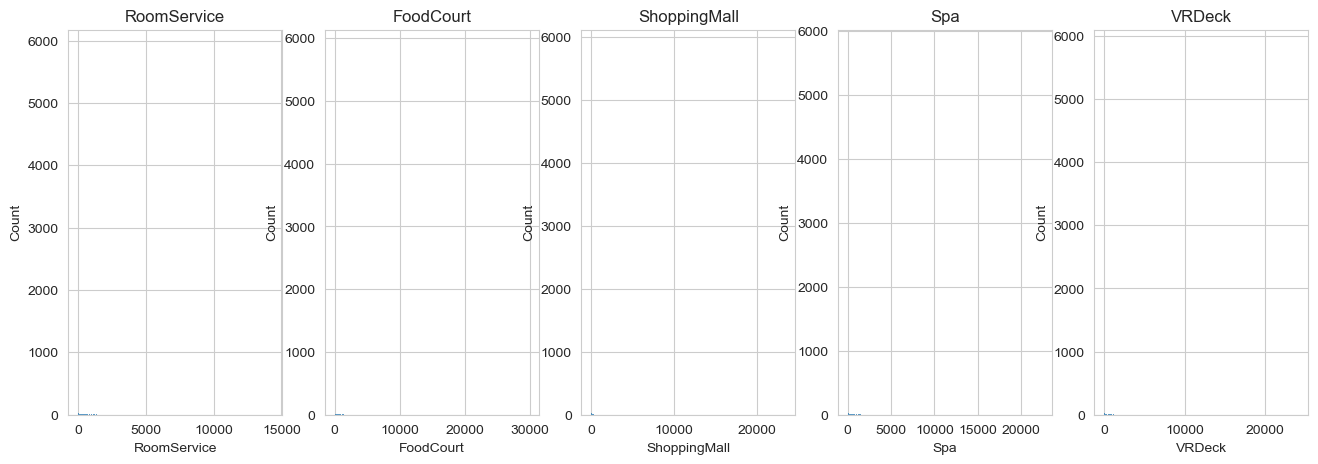

In [16]:
# I'd like to create a totalspend column to aggregate the different areas as this will facilitate for this visualization
train['TotalSpend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

display(sns.violinplot(x='Transported', y='TotalSpend', data=train))

fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i, col in enumerate(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
    sns.histplot(x=train[col], ax=ax[i])
    ax[i].set_title(col)

Seems like we have some huge outliers, let's see who it is that's messing up our graphs:

<AxesSubplot: xlabel='TotalSpend', ylabel='Count'>

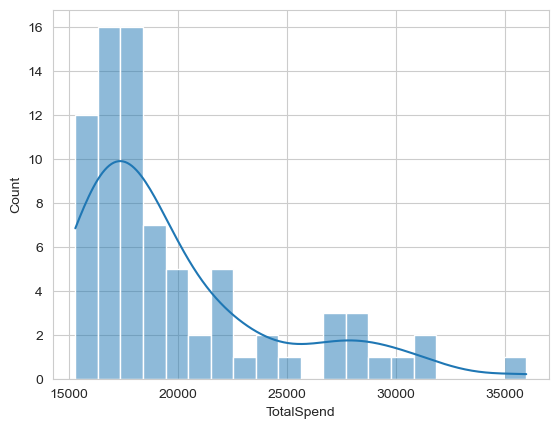

In [18]:
# Seems like we have some exorbitant spenders, let's see who that is:
high_spenders = train[train['TotalSpend'] > train['TotalSpend'].quantile(0.99)]
sns.histplot(x=high_spenders['TotalSpend'], kde=True, bins=20)

Even within our 99% of spenders, there's still a big difference between the lower and upper ends of the spectrum. However, the main thing I've gathered from the `TotalSpend` column is that there are several passengers which seem to never have spent a dime - let's see what percentage of passengers that is:

In [19]:
len(train[train['TotalSpend'] == 0]) / len(train) * 100

37.35189232715979

Roughly **38%** of passengers never even spend a dollar, this highly inflates the `TotalSpend` column and with this number of non-spenders, we should create a new column that describes whether the passenger spent money or not, we can call this new column `Spend`

In [20]:
train['Spend'] = train['TotalSpend'] != 0

With that out of the way, let's continue looking at the data

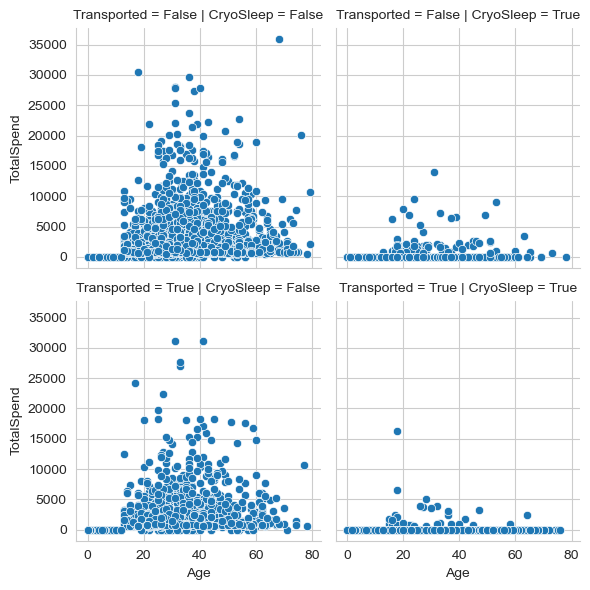

In [21]:
g = sns.FacetGrid(train, col='CryoSleep', row='Transported')
g.map(sns.scatterplot, 'Age', 'TotalSpend')
g.tight_layout()

This is one of those duh moments, where of course those who are in cryosleep are not going to have any sort of spend. In terms of those who were awake, the amount of total spend has a sort of normal distribution with age.

Perhaps a better FacetGrid would be with the VIP column instead:

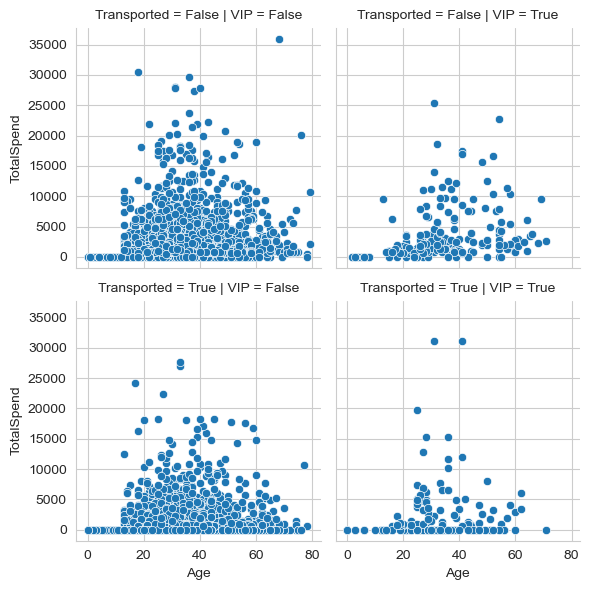

In [22]:
g = sns.FacetGrid(train, col='VIP', row='Transported')
g.map(sns.scatterplot, 'Age', 'TotalSpend')

<AxesSubplot: xlabel='Transported', ylabel='count'>

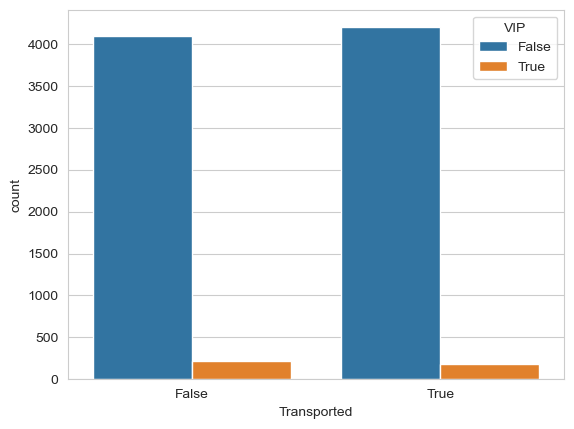

In [23]:
# Nothing too interesting here, but let's look closer at VIP to see if being a VIP was a good indicator of 
# whether you'd get shipped off
sns.countplot(x='Transported', hue='VIP', data=train)

Seems like VIP really makes no difference in the grand scheme of things.

I want to take a look at the `cabin` column, but first let's split the column into something more useful based on description:

In [24]:
train['Side'] = train['Cabin'].str[-1]
train['Deck'] = train['Cabin'].str[0]

<AxesSubplot: xlabel='Deck', ylabel='count'>

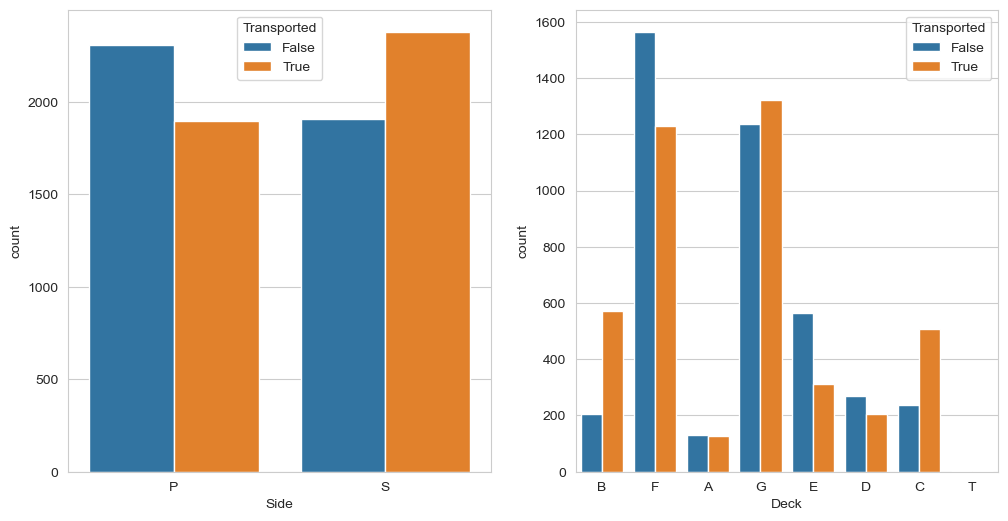

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='Side', hue='Transported', data=train, ax=ax[0])
sns.countplot(x='Deck', hue='Transported', data=train, ax=ax[1])

Seems like the side of the ship you were on has no effect on whether you were or were not transported. Similarly, when looking at the `Deck` column, there does not seem to a great indicator - the closest being **Deck B** where more than half the passengers were transported.

## Model Prep

Since there are several categorical columns I'd like to take advantage of, I'll need to encode them to make it easier for the ML estimator.

For now I'm going to drop the `Name` and `PassengerId` columns since I don't believe they'll add much value.

I'll also be dropping the `TotalSpend` and `Cabin` columns as they are no longer needed.

In [33]:
# Model Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn import metrics

import lightgbm as lgb
import xgboost as xgb
import optuna 

In [27]:
# Dropping the columns we no longer need
train = train.drop(['Cabin', 'TotalSpend', 'Name', 'PassengerId'], axis=1)

In [28]:
# Encoding the nominal data
encoder = OneHotEncoder()
arr = encoder.fit_transform(train[['HomePlanet', 'Destination', 'Side', 'Deck']]).toarray()
encoded_df = pd.DataFrame(data=arr, columns=encoder.get_feature_names_out())

# Creating final dataframe
df_train = pd.concat([train, encoded_df],axis=1).drop(['HomePlanet', 'Destination', 'Side', 'Deck'], axis=1)

In [29]:
# For some dumb reason I thought there was no missing data, that is clearly not the case
df_train.isna().sum() / len(df_train) * 100

CryoSleep                    0.000000
Age                          2.059128
VIP                          0.000000
RoomService                  2.082135
FoodCourt                    2.105142
ShoppingMall                 2.392730
Spa                          2.105142
VRDeck                       2.162660
Transported                  0.000000
Spend                        0.000000
HomePlanet_Earth             0.000000
HomePlanet_Europa            0.000000
HomePlanet_Mars              0.000000
HomePlanet_nan               0.000000
Destination_55 Cancri e      0.000000
Destination_PSO J318.5-22    0.000000
Destination_TRAPPIST-1e      0.000000
Destination_nan              0.000000
Side_P                       0.000000
Side_S                       0.000000
Side_nan                     0.000000
Deck_A                       0.000000
Deck_B                       0.000000
Deck_C                       0.000000
Deck_D                       0.000000
Deck_E                       0.000000
Deck_F      

In [30]:
# Seeing that there's only a small percentage of data missing, we'll drop it for now:
df_train.dropna(inplace=True)

## Modeling
With that all completed, let's train a quick model and see the results:

In [31]:
X = df_train.drop('Transported', axis=1)
y = df_train.Transported

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=101)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_valid)

print(classification_report(y_valid, predictions))

              precision    recall  f1-score   support

       False       0.79      0.85      0.82       767
        True       0.83      0.77      0.80       757

    accuracy                           0.81      1524
   macro avg       0.81      0.81      0.81      1524
weighted avg       0.81      0.81      0.81      1524



While the results are ok, let's do a proper modeling job by optimizing the hyperparameters:

### Optuna w/ Scikit Learn Models

In [32]:
def objective(trial):
    x = df_train.drop('Transported', axis=1)
    y = df_train.Transported

    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 0.1, 1000, log=True)
        svc_gamma = trial.suggest_categorical("svc_gamma", ['auto', 'scale'])
        classifier_obj = SVC(C=svc_c, gamma=svc_gamma)
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 12, log=True)
        rf_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
        rf_split = trial.suggest_int("rf_min_sample_split", 1, 12)
        rf_leaves = trial.suggest_int("rf_leaves", 1, 5)
        classifier_obj = RandomForestClassifier(
            max_depth=rf_max_depth, n_estimators=rf_estimators, min_samples_split=rf_split, min_samples_leaf= rf_leaves
        )

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2022-12-29 20:52:04,846] A new study created in memory with name: no-name-522fb531-e937-43ca-aebd-22a347b6976d
/Users/eliastavarez/opt/anaconda3/envs/jupyter39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eliastavarez/opt/anaconda3/envs/jupyter39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/eliastavarez/opt/anaconda3/envs/jupyter39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[I 2022-12-29 20:52:12,67

FrozenTrial(number=8, values=[0.7969816272965878], datetime_start=datetime.datetime(2022, 12, 29, 20, 52, 23, 392533), datetime_complete=datetime.datetime(2022, 12, 29, 20, 52, 25, 269032), params={'classifier': 'RandomForest', 'rf_max_depth': 9, 'rf_n_estimators': 394, 'rf_min_sample_split': 5, 'rf_leaves': 2}, distributions={'classifier': CategoricalDistribution(choices=('SVC', 'RandomForest')), 'rf_max_depth': IntDistribution(high=12, log=True, low=2, step=1), 'rf_n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'rf_min_sample_split': IntDistribution(high=12, log=False, low=1, step=1), 'rf_leaves': IntDistribution(high=5, log=False, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE, value=None)


As seen from the printouts, the best results came in at **0.7955** from the **Random Forest** model. Using these models was quite slow for even the small amouont of trials we ran, so let's go ahead and now try out optuna with *LightGBM*

### Optuna w/ LightGBM

In [24]:
import lightgbm as lgb
from sklearn import metrics

In [34]:
def objective(trial):
    
    x = df_train.drop('Transported', axis=1)
    y = df_train.Transported
    
    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=7)
    
    d_train = lgb.Dataset(X_train, label=y_train)
    
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1, 
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10, log=True),
        'lambda_l2': trial.suggest_float('labmbda_l2', 1e-8, 10, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1),
        'bagging_freq':  trial.suggest_int("bagging_freq", 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    
    predictions = gbm.predict(X_valid)
    accuracy = metrics.accuracy_score(y_valid, predictions)
    
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)
best_params = study.best_params

[I 2022-12-29 20:52:53,754] A new study created in memory with name: no-name-aa4940ac-704d-468c-9706-6742c09dd0f2


[LightGBM] [Warning] feature_fraction is set=0.17664123845526053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17664123845526053
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5100041744603406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5100041744603406
[LightGBM] [Warning] lambda_l2 is set=1.5193209353490585e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5193209353490585e-06
[LightGBM] [Warning] lambda_l1 is set=4.984171382591875e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.984171382591875e-06


[I 2022-12-29 20:52:54,002] Trial 0 finished with value: 0.7998687664041995 and parameters: {'lambda_l1': 4.984171382591875e-06, 'labmbda_l2': 1.5193209353490585e-06, 'num_leaves': 672, 'feature_fraction': 0.17664123845526053, 'bagging_fraction': 0.5100041744603406, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 0 with value: 0.7998687664041995.
[I 2022-12-29 20:52:54,110] Trial 1 finished with value: 0.7795275590551181 and parameters: {'lambda_l1': 0.001478854491630559, 'labmbda_l2': 1.2273085998467643, 'num_leaves': 991, 'feature_fraction': 0.10513487095604415, 'bagging_fraction': 0.13102079807948128, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 0 with value: 0.7998687664041995.


[LightGBM] [Warning] feature_fraction is set=0.10513487095604415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10513487095604415
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.13102079807948128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13102079807948128
[LightGBM] [Warning] lambda_l2 is set=1.2273085998467643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2273085998467643
[LightGBM] [Warning] lambda_l1 is set=0.001478854491630559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001478854491630559
[LightGBM] [Warning] feature_fraction is set=0.9354327309139507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9354327309139507
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5694937

[I 2022-12-29 20:52:54,404] Trial 2 finished with value: 0.7926509186351706 and parameters: {'lambda_l1': 0.0006196348658011194, 'labmbda_l2': 7.860620023273733e-07, 'num_leaves': 351, 'feature_fraction': 0.9354327309139507, 'bagging_fraction': 0.5694937510675683, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 0 with value: 0.7998687664041995.


[LightGBM] [Warning] feature_fraction is set=0.7734488078298168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7734488078298168
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.27550258488083645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.27550258488083645
[LightGBM] [Warning] lambda_l2 is set=0.11251929657001096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11251929657001096
[LightGBM] [Warning] lambda_l1 is set=4.2049922058947785e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2049922058947785e-06


[I 2022-12-29 20:52:55,327] Trial 3 finished with value: 0.786745406824147 and parameters: {'lambda_l1': 4.2049922058947785e-06, 'labmbda_l2': 0.11251929657001096, 'num_leaves': 907, 'feature_fraction': 0.7734488078298168, 'bagging_fraction': 0.27550258488083645, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 0 with value: 0.7998687664041995.
[I 2022-12-29 20:52:55,514] Trial 4 finished with value: 0.8031496062992126 and parameters: {'lambda_l1': 0.0021197614056560356, 'labmbda_l2': 0.01869004536232924, 'num_leaves': 943, 'feature_fraction': 0.6257854725350923, 'bagging_fraction': 0.25166674902824426, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 4 with value: 0.8031496062992126.


[LightGBM] [Warning] feature_fraction is set=0.6257854725350923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6257854725350923
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.25166674902824426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25166674902824426
[LightGBM] [Warning] lambda_l2 is set=0.01869004536232924, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01869004536232924
[LightGBM] [Warning] lambda_l1 is set=0.0021197614056560356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0021197614056560356
[LightGBM] [Warning] feature_fraction is set=0.9190182351594667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9190182351594667
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.37071

[I 2022-12-29 20:52:55,904] Trial 5 finished with value: 0.7874015748031497 and parameters: {'lambda_l1': 0.013006294617337334, 'labmbda_l2': 0.001718347166901727, 'num_leaves': 297, 'feature_fraction': 0.9190182351594667, 'bagging_fraction': 0.37071512392173345, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 4 with value: 0.8031496062992126.


[LightGBM] [Warning] feature_fraction is set=0.4949151670377301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4949151670377301
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7659923070062384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7659923070062384
[LightGBM] [Warning] lambda_l2 is set=1.3455016953307132e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3455016953307132e-07
[LightGBM] [Warning] lambda_l1 is set=0.013014622274521177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013014622274521177


[I 2022-12-29 20:52:56,258] Trial 6 finished with value: 0.8011811023622047 and parameters: {'lambda_l1': 0.013014622274521177, 'labmbda_l2': 1.3455016953307132e-07, 'num_leaves': 785, 'feature_fraction': 0.4949151670377301, 'bagging_fraction': 0.7659923070062384, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 4 with value: 0.8031496062992126.


[LightGBM] [Warning] feature_fraction is set=0.6972600899002451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6972600899002451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.7983885642543674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7983885642543674
[LightGBM] [Warning] lambda_l2 is set=0.00021625498860952913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021625498860952913
[LightGBM] [Warning] lambda_l1 is set=4.794768156387061e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.794768156387061e-07


[I 2022-12-29 20:52:56,604] Trial 7 finished with value: 0.8031496062992126 and parameters: {'lambda_l1': 4.794768156387061e-07, 'labmbda_l2': 0.00021625498860952913, 'num_leaves': 54, 'feature_fraction': 0.6972600899002451, 'bagging_fraction': 0.7983885642543674, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 4 with value: 0.8031496062992126.
[I 2022-12-29 20:52:56,783] Trial 8 finished with value: 0.7979002624671916 and parameters: {'lambda_l1': 8.91075648111189, 'labmbda_l2': 1.1399515927054777e-08, 'num_leaves': 805, 'feature_fraction': 0.3761038066343848, 'bagging_fraction': 0.8043077555192921, 'bagging_freq': 5, 'min_child_samples': 54}. Best is trial 4 with value: 0.8031496062992126.


[LightGBM] [Warning] feature_fraction is set=0.3761038066343848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3761038066343848
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8043077555192921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8043077555192921
[LightGBM] [Warning] lambda_l2 is set=1.1399515927054777e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1399515927054777e-08
[LightGBM] [Warning] lambda_l1 is set=8.91075648111189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.91075648111189
[LightGBM] [Warning] feature_fraction is set=0.6536494872761676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536494872761676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.91096840526

[I 2022-12-29 20:52:57,017] Trial 9 finished with value: 0.8077427821522309 and parameters: {'lambda_l1': 2.2129514510777407e-06, 'labmbda_l2': 1.6597974831589816e-06, 'num_leaves': 34, 'feature_fraction': 0.6536494872761676, 'bagging_fraction': 0.910968405263584, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:52:57,143] Trial 10 finished with value: 0.797244094488189 and parameters: {'lambda_l1': 1.416626223549079e-05, 'labmbda_l2': 2.2841352310511318e-05, 'num_leaves': 10, 'feature_fraction': 0.42104651619874955, 'bagging_fraction': 0.9732338675365871, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:52:57,231] Trial 11 finished with value: 0.7913385826771654 and parameters: {'lambda_l1': 3.971877888367622e-08, 'labmbda_l2': 0.009647898527918166, 'num_leaves': 527, 'feature_fraction': 0.6711821645787424, 'bagging_fraction': 0.10392322323336375, 'bagging_freq': 

[LightGBM] [Warning] feature_fraction is set=0.42104651619874955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42104651619874955
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9732338675365871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9732338675365871
[LightGBM] [Warning] lambda_l2 is set=2.2841352310511318e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2841352310511318e-05
[LightGBM] [Warning] lambda_l1 is set=1.416626223549079e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.416626223549079e-05
[LightGBM] [Warning] feature_fraction is set=0.6711821645787424, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6711821645787424
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0

[I 2022-12-29 20:52:57,467] Trial 12 finished with value: 0.8064304461942258 and parameters: {'lambda_l1': 1.8881101619880163, 'labmbda_l2': 4.7855096645969055e-05, 'num_leaves': 187, 'feature_fraction': 0.6019137686980279, 'bagging_fraction': 0.9851638805221705, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:52:57,671] Trial 13 finished with value: 0.8044619422572179 and parameters: {'lambda_l1': 7.56819650412812, 'labmbda_l2': 2.2697576987639118e-05, 'num_leaves': 189, 'feature_fraction': 0.8251452888265822, 'bagging_fraction': 0.9909338292813518, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.8251452888265822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8251452888265822
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9909338292813518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9909338292813518
[LightGBM] [Warning] lambda_l2 is set=2.2697576987639118e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2697576987639118e-05
[LightGBM] [Warning] lambda_l1 is set=7.56819650412812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.56819650412812
[LightGBM] [Warning] feature_fraction is set=0.5524435954908441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5524435954908441
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.88472003337

[I 2022-12-29 20:52:57,983] Trial 14 finished with value: 0.797244094488189 and parameters: {'lambda_l1': 0.28796897900359114, 'labmbda_l2': 3.73681664646224e-05, 'num_leaves': 217, 'feature_fraction': 0.5524435954908441, 'bagging_fraction': 0.884720033378834, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.3048295562746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3048295562746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6859692298103792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6859692298103792
[LightGBM] [Warning] lambda_l2 is set=1.5263373362177783e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5263373362177783e-06
[LightGBM] [Warning] lambda_l1 is set=7.7009465702236e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7009465702236e-05


[I 2022-12-29 20:52:58,223] Trial 15 finished with value: 0.8031496062992126 and parameters: {'lambda_l1': 7.7009465702236e-05, 'labmbda_l2': 1.5263373362177783e-06, 'num_leaves': 427, 'feature_fraction': 0.3048295562746, 'bagging_fraction': 0.6859692298103792, 'bagging_freq': 1, 'min_child_samples': 89}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.5412498230324821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5412498230324821
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6449137319426267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6449137319426267
[LightGBM] [Warning] lambda_l2 is set=0.00019776242375928353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019776242375928353
[LightGBM] [Warning] lambda_l1 is set=1.4250486185185992e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4250486185185992e-08


[I 2022-12-29 20:52:58,500] Trial 16 finished with value: 0.80249343832021 and parameters: {'lambda_l1': 1.4250486185185992e-08, 'labmbda_l2': 0.00019776242375928353, 'num_leaves': 150, 'feature_fraction': 0.5412498230324821, 'bagging_fraction': 0.6449137319426267, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.8139728823019547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8139728823019547
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8797773652737259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8797773652737259
[LightGBM] [Warning] lambda_l2 is set=1.1039969347971094e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1039969347971094e-08
[LightGBM] [Warning] lambda_l1 is set=3.89487540889015e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.89487540889015e-07


[I 2022-12-29 20:52:59,083] Trial 17 finished with value: 0.7979002624671916 and parameters: {'lambda_l1': 3.89487540889015e-07, 'labmbda_l2': 1.1039969347971094e-08, 'num_leaves': 108, 'feature_fraction': 0.8139728823019547, 'bagging_fraction': 0.8797773652737259, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.7179551122489727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7179551122489727
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8929993660704365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8929993660704365
[LightGBM] [Warning] lambda_l2 is set=2.654234808754747e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.654234808754747e-07
[LightGBM] [Warning] lambda_l1 is set=0.2262474486002696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2262474486002696


[I 2022-12-29 20:52:59,440] Trial 18 finished with value: 0.8038057742782152 and parameters: {'lambda_l1': 0.2262474486002696, 'labmbda_l2': 2.654234808754747e-07, 'num_leaves': 549, 'feature_fraction': 0.7179551122489727, 'bagging_fraction': 0.8929993660704365, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6121361818197749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6121361818197749
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.47051436552634973, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47051436552634973
[LightGBM] [Warning] lambda_l2 is set=1.0855697957706886e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0855697957706886e-05
[LightGBM] [Warning] lambda_l1 is set=0.00010248946210101204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010248946210101204


[I 2022-12-29 20:52:59,731] Trial 19 finished with value: 0.8064304461942258 and parameters: {'lambda_l1': 0.00010248946210101204, 'labmbda_l2': 1.0855697957706886e-05, 'num_leaves': 313, 'feature_fraction': 0.6121361818197749, 'bagging_fraction': 0.47051436552634973, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.4450696176338725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4450696176338725
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6999238120741383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999238120741383
[LightGBM] [Warning] lambda_l2 is set=0.0014741039449382067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014741039449382067
[LightGBM] [Warning] lambda_l1 is set=0.48139263637803015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48139263637803015


[I 2022-12-29 20:53:00,417] Trial 20 finished with value: 0.80249343832021 and parameters: {'lambda_l1': 0.48139263637803015, 'labmbda_l2': 0.0014741039449382067, 'num_leaves': 252, 'feature_fraction': 0.4450696176338725, 'bagging_fraction': 0.6999238120741383, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.5846397280699661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5846397280699661
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4558047783875492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4558047783875492
[LightGBM] [Warning] lambda_l2 is set=4.79253809798942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.79253809798942e-06
[LightGBM] [Warning] lambda_l1 is set=0.0001642622743007748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001642622743007748


[I 2022-12-29 20:53:00,676] Trial 21 finished with value: 0.80249343832021 and parameters: {'lambda_l1': 0.0001642622743007748, 'labmbda_l2': 4.79253809798942e-06, 'num_leaves': 384, 'feature_fraction': 0.5846397280699661, 'bagging_fraction': 0.4558047783875492, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6112104689997439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6112104689997439
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.39582947442747685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.39582947442747685
[LightGBM] [Warning] lambda_l2 is set=1.4520400827185889e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4520400827185889e-05
[LightGBM] [Warning] lambda_l1 is set=3.495882903681689e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.495882903681689e-05


[I 2022-12-29 20:53:00,929] Trial 22 finished with value: 0.8011811023622047 and parameters: {'lambda_l1': 3.495882903681689e-05, 'labmbda_l2': 1.4520400827185889e-05, 'num_leaves': 101, 'feature_fraction': 0.6112104689997439, 'bagging_fraction': 0.39582947442747685, 'bagging_freq': 7, 'min_child_samples': 72}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.319770106660778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.319770106660778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.6056716520493549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6056716520493549
[LightGBM] [Warning] lambda_l2 is set=0.0001248267391792615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001248267391792615
[LightGBM] [Warning] lambda_l1 is set=1.25159467254535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.25159467254535e-06


[I 2022-12-29 20:53:01,277] Trial 23 finished with value: 0.8070866141732284 and parameters: {'lambda_l1': 1.25159467254535e-06, 'labmbda_l2': 0.0001248267391792615, 'num_leaves': 299, 'feature_fraction': 0.319770106660778, 'bagging_fraction': 0.6056716520493549, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.22948229674088877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22948229674088877
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5942074903461266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5942074903461266
[LightGBM] [Warning] lambda_l2 is set=9.78874049841783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.78874049841783e-08
[LightGBM] [Warning] lambda_l1 is set=3.339372519644377e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.339372519644377e-07


[I 2022-12-29 20:53:01,570] Trial 24 finished with value: 0.7874015748031497 and parameters: {'lambda_l1': 3.339372519644377e-07, 'labmbda_l2': 9.78874049841783e-08, 'num_leaves': 436, 'feature_fraction': 0.22948229674088877, 'bagging_fraction': 0.5942074903461266, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.3824759924606783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3824759924606783
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9462137091070324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9462137091070324
[LightGBM] [Warning] lambda_l2 is set=8.925598823606011e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.925598823606011e-05
[LightGBM] [Warning] lambda_l1 is set=2.3462957714996557e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3462957714996557e-06


[I 2022-12-29 20:53:01,920] Trial 25 finished with value: 0.8057742782152231 and parameters: {'lambda_l1': 2.3462957714996557e-06, 'labmbda_l2': 8.925598823606011e-05, 'num_leaves': 171, 'feature_fraction': 0.3824759924606783, 'bagging_fraction': 0.9462137091070324, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.4671885741437569, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4671885741437569
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.8353486335501983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353486335501983
[LightGBM] [Warning] lambda_l2 is set=0.000737629078797188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000737629078797188
[LightGBM] [Warning] lambda_l1 is set=7.388074712993362e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.388074712993362e-08


[I 2022-12-29 20:53:02,498] Trial 26 finished with value: 0.8031496062992126 and parameters: {'lambda_l1': 7.388074712993362e-08, 'labmbda_l2': 0.000737629078797188, 'num_leaves': 254, 'feature_fraction': 0.4671885741437569, 'bagging_fraction': 0.8353486335501983, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.3176644972880231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3176644972880231
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4456813756687866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4456813756687866
[LightGBM] [Warning] lambda_l2 is set=4.637538715633077e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.637538715633077e-06
[LightGBM] [Warning] lambda_l1 is set=1.1046006208262352e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1046006208262352e-06


[I 2022-12-29 20:53:04,503] Trial 27 finished with value: 0.8011811023622047 and parameters: {'lambda_l1': 1.1046006208262352e-06, 'labmbda_l2': 4.637538715633077e-06, 'num_leaves': 638, 'feature_fraction': 0.3176644972880231, 'bagging_fraction': 0.4456813756687866, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.5208741876264168, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5208741876264168
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.5139217895005644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5139217895005644
[LightGBM] [Warning] lambda_l2 is set=7.584979316223579e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.584979316223579e-06
[LightGBM] [Warning] lambda_l1 is set=2.4869171714940456e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4869171714940456e-05


[I 2022-12-29 20:53:04,971] Trial 28 finished with value: 0.7992125984251969 and parameters: {'lambda_l1': 2.4869171714940456e-05, 'labmbda_l2': 7.584979316223579e-06, 'num_leaves': 344, 'feature_fraction': 0.5208741876264168, 'bagging_fraction': 0.5139217895005644, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:05,185] Trial 29 finished with value: 0.7906824146981627 and parameters: {'lambda_l1': 5.862372196282013e-06, 'labmbda_l2': 9.345107910750253, 'num_leaves': 80, 'feature_fraction': 0.20902223037137596, 'bagging_fraction': 0.9131243767033461, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.20902223037137596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20902223037137596
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9131243767033461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9131243767033461
[LightGBM] [Warning] lambda_l2 is set=9.345107910750253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.345107910750253
[LightGBM] [Warning] lambda_l1 is set=5.862372196282013e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.862372196282013e-06
[LightGBM] [Warning] feature_fraction is set=0.7405131612403885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7405131612403885
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.321664572

[I 2022-12-29 20:53:05,577] Trial 30 finished with value: 0.7933070866141733 and parameters: {'lambda_l1': 0.00013077089048106367, 'labmbda_l2': 4.2488237776599706e-07, 'num_leaves': 623, 'feature_fraction': 0.7405131612403885, 'bagging_fraction': 0.32166457201308907, 'bagging_freq': 6, 'min_child_samples': 27}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6176396678414734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6176396678414734
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7569970528188119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7569970528188119
[LightGBM] [Warning] lambda_l2 is set=7.454117441095705e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.454117441095705e-05
[LightGBM] [Warning] lambda_l1 is set=0.012243471596185752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012243471596185752


[I 2022-12-29 20:53:05,930] Trial 31 finished with value: 0.8038057742782152 and parameters: {'lambda_l1': 0.012243471596185752, 'labmbda_l2': 7.454117441095705e-05, 'num_leaves': 291, 'feature_fraction': 0.6176396678414734, 'bagging_fraction': 0.7569970528188119, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:06,072] Trial 32 finished with value: 0.7893700787401575 and parameters: {'lambda_l1': 8.63927598765809e-06, 'labmbda_l2': 2.141618869455611e-06, 'num_leaves': 22, 'feature_fraction': 0.11160740015009854, 'bagging_fraction': 0.618186475554775, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.11160740015009854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11160740015009854
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.618186475554775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.618186475554775
[LightGBM] [Warning] lambda_l2 is set=2.141618869455611e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.141618869455611e-06
[LightGBM] [Warning] lambda_l1 is set=8.63927598765809e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.63927598765809e-06
[LightGBM] [Warning] feature_fraction is set=0.6624783616736423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6624783616736423
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.52103

[I 2022-12-29 20:53:06,358] Trial 33 finished with value: 0.8070866141732284 and parameters: {'lambda_l1': 0.0009332083771240179, 'labmbda_l2': 0.0057189469841588455, 'num_leaves': 129, 'feature_fraction': 0.6624783616736423, 'bagging_fraction': 0.5210395248744486, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6689173245659944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6689173245659944
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5232020362760369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5232020362760369
[LightGBM] [Warning] lambda_l2 is set=0.006877664583192224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006877664583192224
[LightGBM] [Warning] lambda_l1 is set=0.0010337698357751983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010337698357751983


[I 2022-12-29 20:53:06,620] Trial 34 finished with value: 0.800524934383202 and parameters: {'lambda_l1': 0.0010337698357751983, 'labmbda_l2': 0.006877664583192224, 'num_leaves': 121, 'feature_fraction': 0.6689173245659944, 'bagging_fraction': 0.5232020362760369, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:06,754] Trial 35 finished with value: 0.797244094488189 and parameters: {'lambda_l1': 0.06856987083653106, 'labmbda_l2': 0.09300177208737997, 'num_leaves': 226, 'feature_fraction': 0.7851243082434873, 'bagging_fraction': 0.2000008854351052, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.7851243082434873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7851243082434873
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.2000008854351052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2000008854351052
[LightGBM] [Warning] lambda_l2 is set=0.09300177208737997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09300177208737997
[LightGBM] [Warning] lambda_l1 is set=0.06856987083653106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06856987083653106
[LightGBM] [Warning] feature_fraction is set=0.8971346326217244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8971346326217244
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.45805771953

[I 2022-12-29 20:53:07,254] Trial 36 finished with value: 0.7913385826771654 and parameters: {'lambda_l1': 0.00033333464453971345, 'labmbda_l2': 0.09608891596149631, 'num_leaves': 460, 'feature_fraction': 0.8971346326217244, 'bagging_fraction': 0.4580577195306815, 'bagging_freq': 7, 'min_child_samples': 48}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.8718849572368206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718849572368206
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.7123620208516468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7123620208516468
[LightGBM] [Warning] lambda_l2 is set=0.0004907573167663099, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004907573167663099
[LightGBM] [Warning] lambda_l1 is set=1.4322576835991772, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4322576835991772


[I 2022-12-29 20:53:07,985] Trial 37 finished with value: 0.8051181102362205 and parameters: {'lambda_l1': 1.4322576835991772, 'labmbda_l2': 0.0004907573167663099, 'num_leaves': 158, 'feature_fraction': 0.8718849572368206, 'bagging_fraction': 0.7123620208516468, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6523963739803904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6523963739803904
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.3803085349153741, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3803085349153741
[LightGBM] [Warning] lambda_l2 is set=0.0023737967556953996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023737967556953996
[LightGBM] [Warning] lambda_l1 is set=0.0036955769603347973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036955769603347973


[I 2022-12-29 20:53:08,281] Trial 38 finished with value: 0.7992125984251969 and parameters: {'lambda_l1': 0.0036955769603347973, 'labmbda_l2': 0.0023737967556953996, 'num_leaves': 319, 'feature_fraction': 0.6523963739803904, 'bagging_fraction': 0.3803085349153741, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.9987488227439258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9987488227439258
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.5356405722142183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5356405722142183
[LightGBM] [Warning] lambda_l2 is set=0.40532115152888415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.40532115152888415
[LightGBM] [Warning] lambda_l1 is set=1.4067569095715288e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4067569095715288e-06


[I 2022-12-29 20:53:08,537] Trial 39 finished with value: 0.7952755905511811 and parameters: {'lambda_l1': 1.4067569095715288e-06, 'labmbda_l2': 0.40532115152888415, 'num_leaves': 379, 'feature_fraction': 0.9987488227439258, 'bagging_fraction': 0.5356405722142183, 'bagging_freq': 6, 'min_child_samples': 45}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.7631414411004859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631414411004859
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5732915705408119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5732915705408119
[LightGBM] [Warning] lambda_l2 is set=0.024819941007198257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024819941007198257
[LightGBM] [Warning] lambda_l1 is set=1.7528111533795562e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7528111533795562e-07


[I 2022-12-29 20:53:08,795] Trial 40 finished with value: 0.8018372703412073 and parameters: {'lambda_l1': 1.7528111533795562e-07, 'labmbda_l2': 0.024819941007198257, 'num_leaves': 53, 'feature_fraction': 0.7631414411004859, 'bagging_fraction': 0.5732915705408119, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:09,007] Trial 41 finished with value: 0.7979002624671916 and parameters: {'lambda_l1': 4.636514620266507e-05, 'labmbda_l2': 6.018037315395106e-05, 'num_leaves': 284, 'feature_fraction': 0.7053368270851692, 'bagging_fraction': 0.4837419312170376, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.7053368270851692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7053368270851692
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.4837419312170376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4837419312170376
[LightGBM] [Warning] lambda_l2 is set=6.018037315395106e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.018037315395106e-05
[LightGBM] [Warning] lambda_l1 is set=4.636514620266507e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.636514620266507e-05


[I 2022-12-29 20:53:09,199] Trial 42 finished with value: 0.800524934383202 and parameters: {'lambda_l1': 0.0026722090886183813, 'labmbda_l2': 0.00015993195728838142, 'num_leaves': 135, 'feature_fraction': 0.5788965788634999, 'bagging_fraction': 0.4144022474475013, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.5788965788634999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5788965788634999
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.4144022474475013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4144022474475013
[LightGBM] [Warning] lambda_l2 is set=0.00015993195728838142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015993195728838142
[LightGBM] [Warning] lambda_l1 is set=0.0026722090886183813, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026722090886183813
[LightGBM] [Warning] feature_fraction is set=0.4935598949478875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4935598949478875
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.3

[I 2022-12-29 20:53:09,373] Trial 43 finished with value: 0.8064304461942258 and parameters: {'lambda_l1': 0.03861142778175786, 'labmbda_l2': 4.0810333489098426e-08, 'num_leaves': 210, 'feature_fraction': 0.4935598949478875, 'bagging_fraction': 0.3366806778365887, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:09,502] Trial 44 finished with value: 0.8018372703412073 and parameters: {'lambda_l1': 0.03951579614029074, 'labmbda_l2': 4.317271872019284e-08, 'num_leaves': 71, 'feature_fraction': 0.49513401309360733, 'bagging_fraction': 0.30973567869433183, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.49513401309360733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49513401309360733
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.30973567869433183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30973567869433183
[LightGBM] [Warning] lambda_l2 is set=4.317271872019284e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.317271872019284e-08
[LightGBM] [Warning] lambda_l1 is set=0.03951579614029074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03951579614029074
[LightGBM] [Warning] feature_fraction is set=0.6613934872068629, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613934872068629
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.998

[I 2022-12-29 20:53:09,940] Trial 45 finished with value: 0.8038057742782152 and parameters: {'lambda_l1': 0.0004665406979360625, 'labmbda_l2': 1.8275445849433455e-06, 'num_leaves': 255, 'feature_fraction': 0.6613934872068629, 'bagging_fraction': 0.998591843866167, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:10,066] Trial 46 finished with value: 0.7933070866141733 and parameters: {'lambda_l1': 3.8914955170991305e-06, 'labmbda_l2': 3.364703455540164e-08, 'num_leaves': 222, 'feature_fraction': 0.2934672320058008, 'bagging_fraction': 0.20842697430292106, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.2934672320058008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2934672320058008
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.20842697430292106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20842697430292106
[LightGBM] [Warning] lambda_l2 is set=3.364703455540164e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.364703455540164e-08
[LightGBM] [Warning] lambda_l1 is set=3.8914955170991305e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8914955170991305e-06
[LightGBM] [Warning] feature_fraction is set=0.5737428849745956, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5737428849745956
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0

[I 2022-12-29 20:53:10,301] Trial 47 finished with value: 0.800524934383202 and parameters: {'lambda_l1': 1.774707026084766e-05, 'labmbda_l2': 0.004069470174063868, 'num_leaves': 35, 'feature_fraction': 0.5737428849745956, 'bagging_fraction': 0.9341926776208629, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.6257361512100865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6257361512100865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6555958297569493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6555958297569493
[LightGBM] [Warning] lambda_l2 is set=1.1109043198288154e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1109043198288154e-05
[LightGBM] [Warning] lambda_l1 is set=8.390920341150058e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.390920341150058e-07


[I 2022-12-29 20:53:10,699] Trial 48 finished with value: 0.7992125984251969 and parameters: {'lambda_l1': 8.390920341150058e-07, 'labmbda_l2': 1.1109043198288154e-05, 'num_leaves': 176, 'feature_fraction': 0.6257361512100865, 'bagging_fraction': 0.6555958297569493, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 9 with value: 0.8077427821522309.
[I 2022-12-29 20:53:10,846] Trial 49 finished with value: 0.7998687664041995 and parameters: {'lambda_l1': 0.005779125302381732, 'labmbda_l2': 8.10003696470055e-07, 'num_leaves': 331, 'feature_fraction': 0.39937279391626757, 'bagging_fraction': 0.34000643174559936, 'bagging_freq': 4, 'min_child_samples': 92}. Best is trial 9 with value: 0.8077427821522309.


[LightGBM] [Warning] feature_fraction is set=0.39937279391626757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39937279391626757
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.34000643174559936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.34000643174559936
[LightGBM] [Warning] lambda_l2 is set=8.10003696470055e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.10003696470055e-07
[LightGBM] [Warning] lambda_l1 is set=0.005779125302381732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005779125302381732
FrozenTrial(number=9, values=[0.8077427821522309], datetime_start=datetime.datetime(2022, 12, 29, 20, 52, 56, 783644), datetime_complete=datetime.datetime(2022, 12, 29, 20, 52, 57, 17277), params={'lambda_l1': 2.2129514510777407e-06, 'labmbda_l2': 1.6597974831589816e-06, 'num_leaves': 34, 'feature_fraction': 0.

The *lightGBM* model runs a lot faster, so much so that I chose to do 50 trials and it ran quite quickly. From the printout, we can see that our best results came in at **0.8103** which is great!

## Modeling - Test

In [36]:
# Read and prepare data
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_test = test.copy()
df_test.head()

# Adding columns
df_test['Side'] = df_test['Cabin'].str[-1]
df_test['Deck'] = df_test['Cabin'].str[0]
df_test['Spend'] = df_test[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1) != 0

# Dropping the columns we no longer need
df_test = df_test.drop(['Cabin', 'Name'], axis=1)

# Mapping the T/F columns to 1/0s
train[['CryoSleep', 'VIP']] = train[['CryoSleep', 'VIP']].astype(bool)

# Encoding the nominal data
encoder = OneHotEncoder()
arr = encoder.fit_transform(df_test[['HomePlanet', 'Destination', 'Side', 'Deck']]).toarray()
encoded_df = pd.DataFrame(data=arr, columns=encoder.get_feature_names_out())

# Creating final dataframe
df_test = pd.concat([df_test, encoded_df],axis=1).drop(['HomePlanet', 'Destination', 'Side', 'Deck'], axis=1)

df_test = df_test.fillna(method='backfill')

labels = df_test.PassengerId

df_test = df_test.drop('PassengerId', axis=1)

In [37]:
model = lgb.LGBMClassifier(**best_params)
model.fit(df_train.drop('Transported', axis=1), df_train.Transported)
predictions = model.predict(df_test)

[LightGBM] [Warning] Unknown parameter: labmbda_l2
[LightGBM] [Warning] bagging_fraction is set=0.910968405263584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.910968405263584
[LightGBM] [Warning] feature_fraction is set=0.6536494872761676, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6536494872761676
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=2.2129514510777407e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2129514510777407e-06


In [38]:
final_df = pd.concat([labels, pd.Series(predictions)], axis=1, ignore_index=True)
final_df.columns = ['PassengerId', 'Transported']

In [39]:
# Finally, send the data to csv
final_df.to_csv(os.path.join(DATA_PATH, 'submission.csv'), index=False)